In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.image import rgb_to_grayscale
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import os

In [6]:
mannequin_path = os.path.join('../','EventsFrame_19012020/upscaled_data_twoClass/mannequin')
not_mannequin_path = os.path.join('../','EventsFrame_19012020/upscaled_data_twoClass/not_mannequin')

mannequin_img_path = [os.path.join(mannequin_path,x) for x in os.listdir(mannequin_path)]
not_mannequin_img_path = [os.path.join(not_mannequin_path,x) for x in os.listdir(not_mannequin_path)]

print(mannequin_img_path[:5])
print(not_mannequin_img_path[:5])

random.shuffle(mannequin_img_path)
random.shuffle(mannequin_img_path)
random.shuffle(not_mannequin_img_path)
random.shuffle(not_mannequin_img_path)

print(mannequin_img_path[:5])
print(not_mannequin_img_path[:5])

['../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2409.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/446.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2938.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2717.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2049.png']
['../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2409.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/446.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2717.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2049.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/1458.png']
['../EventsFrame_19012020/upscaled_data_twoClass/mannequin/1991.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/1833.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2061.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/752.png', '../EventsFram

In [7]:
train_mannequin_img, test_mannequin_img = train_test_split(mannequin_img_path,test_size = 0.25,random_state=42)
train_mannequin_img, val_mannequin_img = train_test_split(train_mannequin_img,test_size = 0.25,random_state=42)


In [8]:
test_not_mannequin_img,val_not_mannequin_img = train_test_split(not_mannequin_img_path,test_size = 0.25, random_state=42)

In [9]:
def generate_label_list(path,test_img_path):
    
    label_list = []
    for x in path:
        if x in test_img_path:
            label_list.append(1)
        else:
            label_list.append(0)
    return label_list

In [10]:
all_test_paths = test_mannequin_img + test_not_mannequin_img
random.shuffle(all_test_paths)
test_label_list = generate_label_list(all_test_paths,test_mannequin_img)

all_val_paths = val_mannequin_img + val_not_mannequin_img
random.shuffle(all_val_paths)
val_label_list = generate_label_list(all_val_paths,val_mannequin_img)


In [11]:
print(test_label_list[-8:])
print(all_test_paths[-8:])

[0, 0, 0, 0, 1, 0, 0, 0]
['../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/20.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2131.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/166.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/871.png', '../EventsFrame_19012020/upscaled_data_twoClass/mannequin/2618.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2200.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/2355.png', '../EventsFrame_19012020/upscaled_data_twoClass/not_mannequin/1354.png']


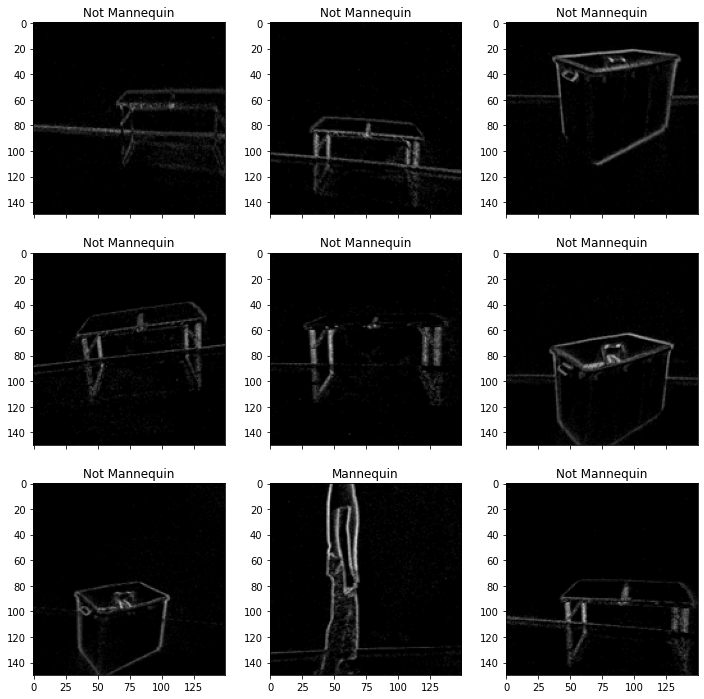

In [15]:
fig,axes = plt.subplots(3,3,sharex=True,figsize=(12,12))
for ax in axes.ravel():
    label = 'Not Mannequin'
    img = np.random.choice(all_test_paths)
    temp = img.split('/')
    label = 'Not Mannequin' if temp[3][0] == 'n' else 'Mannequin'
    img = load_img(img,target_size=(150,150),interpolation='bicubic')
    ax.imshow(img)
    ax.set_title(label)




In [17]:
image_size = 150
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width),interpolation='bicubic') for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)


In [18]:
imgs=load_img(train_mannequin_img[3],target_size=(224, 224),interpolation='bicubic')
img_array = img_to_array(imgs)

In [20]:
X_train = read_and_prep_images(train_mannequin_img)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)


In [31]:
X_test.shape

(2921, 150, 150, 3)

In [32]:
resnet_model = ResNet50(include_top = False, weights='imagenet',input_shape=(150,150,3))
resnet_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(resnet_model.output)
model = tf.keras.Model(resnet_model.input,x)
# model = resnet_model

In [33]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [34]:
train = resnet_model.predict(X_train)
test = resnet_model.predict(X_test)
X_train = model.predict(X_train)
X_test = model.predict(X_test)
X_val = model.predict(X_val)


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm

In [36]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.94


In [37]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.00001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

In [38]:
oc_svm_preds


array([-1, -1, -1, ..., -1, -1, -1])

In [39]:
if_preds[0:10]

array([-1, -1, -1, -1, -1,  1,  1,  1,  1, -1])

In [40]:
if_preds_modified = []
for i in range(len(if_preds)):
    if if_preds[i] == -1:
        if_preds_modified.append(0)
        
    else:
        if_preds_modified.append(1)

oc_svm_pred_modified = []
for i in range(len(oc_svm_preds)):
    if oc_svm_preds[i] == -1:
        oc_svm_pred_modified.append(0)
        
    else:
        oc_svm_pred_modified.append(1)


In [41]:
print(roc_auc_score(test_label_list,if_preds_modified))

0.9657869740707188


In [42]:
print(roc_auc_score(test_label_list,oc_svm_pred_modified))

0.9684289819967427


In [43]:
print(oc_svm_clf.score_samples(X_test))

[100.0917319  113.93505952 119.36192633 ... 133.33710633 130.98202435
 124.72638784]
